### Importar bibliotecas

In [83]:
# Conexão com BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
# Manipulação de dados
import pandas as pd
import numpy as np
import warnings
# Plotagem de dados
import matplotlib.pyplot as plt
# Módulos Estatísticos
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
# Métricas de Modelos e Estatísticas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import scipy.stats as stats
# Modelo ARIMA e SARIMA
from pmdarima.arima import auto_arima

### Criar conexão com os dados no GCP

In [84]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

### Criar dataframe com os dados já tratados e selecionados

In [ ]:
# Os dados de mortalidade já foram tratados na ETL para calcular o YLL por cada óbito
# Aqui esta importação já está trazendo a taxa média do YLL dos municípios de médio porte por quedrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

In [86]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [87]:
# Ver os dados iniciais
df.head()

,quadrimestre,taxa_media_yll
0,2010-04-30,6.427726
1,2010-08-31,6.767661
2,2010-12-31,6.111099
3,2011-04-30,6.550037
4,2011-08-31,6.878076


In [88]:
# Ver os tipos de dados
df.dtypes

quadrimestre       dbdate
taxa_media_yll    float64
dtype: object

### Cópia do DataFrame para manipulação e criação dos modelos

In [89]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [90]:
# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

In [91]:
# Ver os tipos de dados
time_series.dtypes

quadrimestre      datetime64[ns]
taxa_media_yll           float64
dtype: object

In [92]:
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

In [93]:
# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('quadrimestre')

In [94]:
time_series

,taxa_media_yll
quadrimestre,
2010-04-30,6.427726
2010-08-31,6.767661
2010-12-31,6.111099
2011-04-30,6.550037
2011-08-31,6.878076
2011-12-31,5.804813
2012-04-30,6.280719
2012-08-31,6.739170
2012-12-31,6.049970


### Decomposição da série

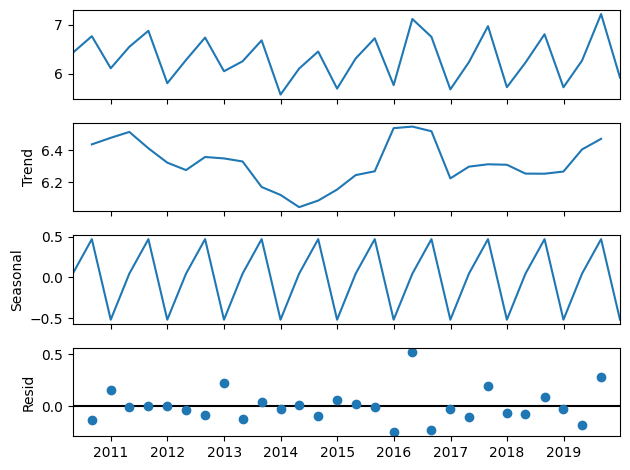

In [95]:
# Plotar decomposição da série temporal
result = seasonal_decompose(time_series, model='additive', period=3)
result.plot()
plt.show()

### Teste de Estacionariedade

In [96]:
# Função para testar a estacionaridade
def teste_adf(serie):
    result = adfuller(serie)
    print('ADF Estatíticas: %f' % result[0])
    print('Valor de P: %f' % result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

In [97]:
# Executa o teste de estacionaridade em 'taxa_media_yll'
X = time_series['taxa_media_yll']
teste_adf(X)

ADF Estatíticas: -2.343977
Valor de P: 0.158176
Valores Críticos:
	1%: -3.753
	5%: -2.998
	10%: -2.639
A série não é estacionária.


<Axes: xlabel='quadrimestre'>

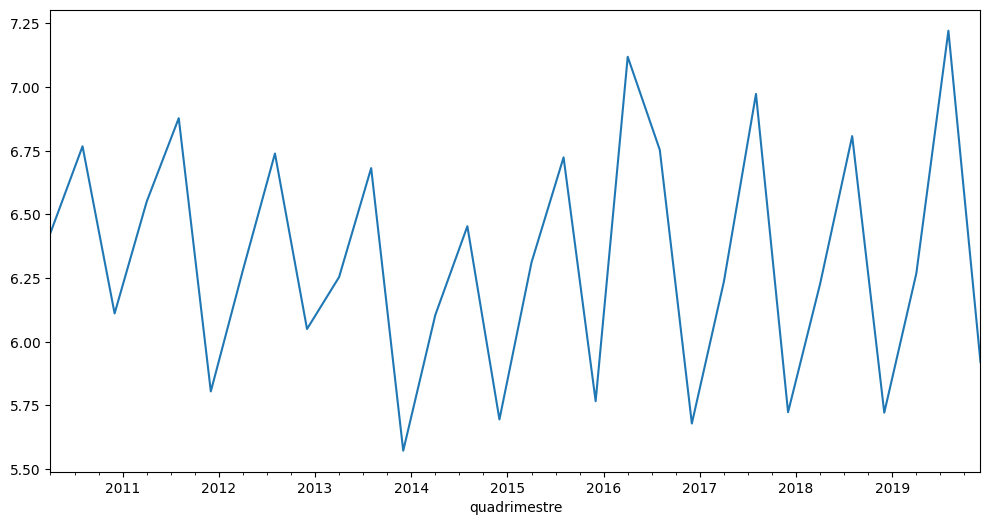

In [98]:
plt.figure(figsize=(12, 6))
X.plot()

### Tornando a série estacionária com diferenciação simples

<Axes: xlabel='quadrimestre'>

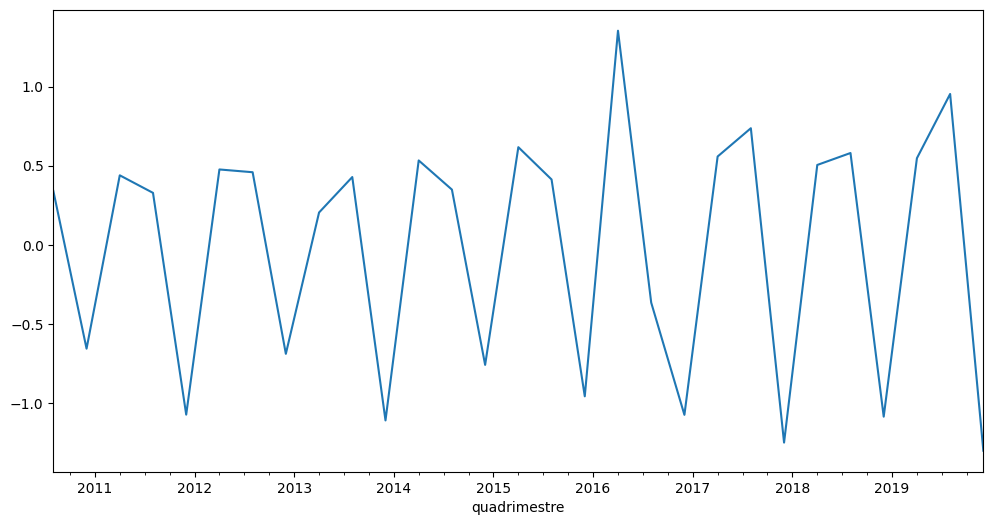

In [61]:
# Diferenciação simples
xdiff = X.diff().dropna()
xlabel='Data'
plt.figure(figsize=(12, 6))
xdiff.plot()

In [62]:
# Verifica novamente a estacionaridade após a diferenciação
teste_adf(xdiff)

ADF Estatíticas: -18.396229
Valor de P: 0.000000
Valores Críticos:
	1%: -3.700
	5%: -2.976
	10%: -2.628
A série é estacionária.


### Metodos Para Calcular o Theil's U Coefficient

In [64]:
# Calcular o erro Theil's U2
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

### ARIMA

In [65]:
X = time_series['taxa_media_yll']

In [66]:
arima_model = auto_arima(X,
                         start_p=1, start_q=1,
                         max_p=6, max_q=6,
                         seasonal=False,  # Definindo como False para um modelo ARIMA
                         d=1, D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.834, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.096, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.849, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22.185, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24.048, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24.065, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26.045, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=20.186, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.102, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=22.049, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=22.066, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=24.047, Time=0.05 sec

Best 

In [67]:
train = X.loc[:'2016-12-31']
test = X.loc['2017-01-01':]

In [68]:
arima_model.fit(train)

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [69]:
future_forecast_arima = arima_model.predict(n_periods=9)

In [70]:
future_forecast_arima.index

DatetimeIndex(['2017-04-30', '2017-08-31', '2017-12-31', '2018-04-30',
               '2018-08-31', '2018-12-31', '2019-04-30', '2019-08-31',
               '2019-12-31'],
              dtype='datetime64[ns]', freq='4ME')

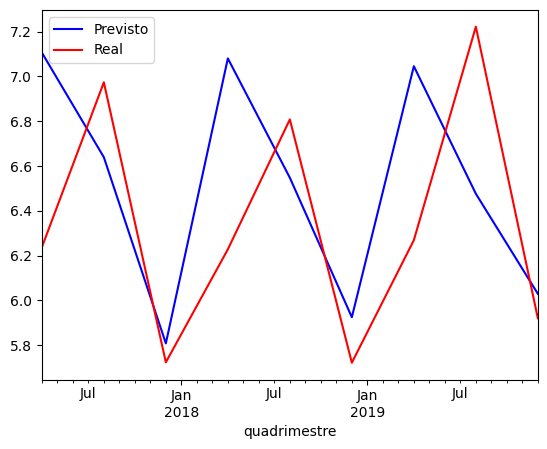

In [74]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
test.plot(marker='', color='red', label='Real', legend=True)
plt.show()

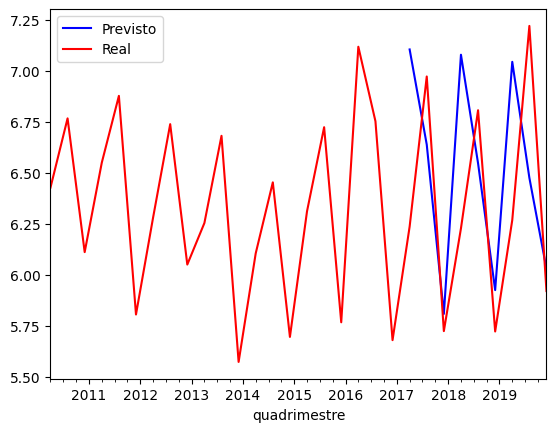

In [78]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)
plt.show()

In [79]:
# Parâmetros para calcular os intervalos de confiança

alpha_95 = 0.05 # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2 # Nível de significância para intervalo de confiança de 80%

# Valor crítico para distribuição normal padrão
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = future_forecast_arima
forecast_std = np.std(train)

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

In [80]:
future_forecast_arima

2017-04-30    7.105948
2017-08-31    6.638804
2017-12-31    5.807755
2018-04-30    7.080053
2018-08-31    6.547224
2018-12-31    5.924549
2019-04-30    7.045135
2019-08-31    6.475837
2019-12-31    6.029070
Freq: 4ME, dtype: float64

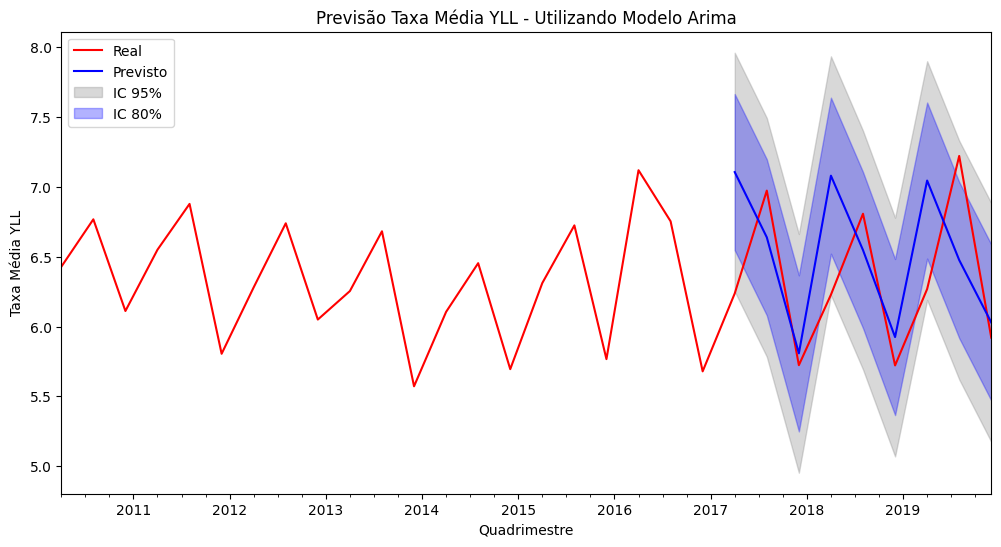

In [81]:
# Plotar previsão vs real com ambos intervalos de confiança
plt.figure(figsize=(12, 6))

X.plot(marker='', color='red', legend=True, label='Real')
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')

# Intervalo de 95%
plt.fill_between(future_forecast_arima.index,
                 lower_bound_95, upper_bound_95,
                 color='gray', alpha=0.3, label='IC 95%')

# Intervalo de 80%
plt.fill_between(future_forecast_arima.index,
                 lower_bound_80, upper_bound_80,
                 color='blue', alpha=0.3, label='IC 80%')

plt.title('Previsão Taxa Média YLL - Utilizando Modelo Arima')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Quadrimestre')
plt.legend()
# plt.grid(True)
plt.show()

In [82]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test,future_forecast_arima)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test,future_forecast_arima)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(test,future_forecast_arima)
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
TU = theil_u2(test, future_forecast_arima)
print(f'TU: {TU}')

# Teste de Durbin-Watson
model_fit = arima_model.fit(train)
dw = durbin_watson(model_fit.resid())
print(f'Durbin-Watson: {dw}')

MAE: 0.4705993445947998
MSE: 0.320135543826883
RMSE: 0.5658052172142662
MAPE: 0.07314334049314963
TU: 0.4705008356932639
Durbin-Watson: 0.9314454459886604


### SARIMA

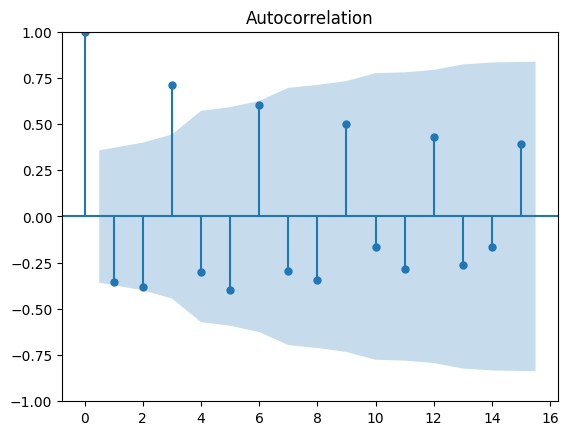

In [126]:
plot_acf(X)
plt.show()

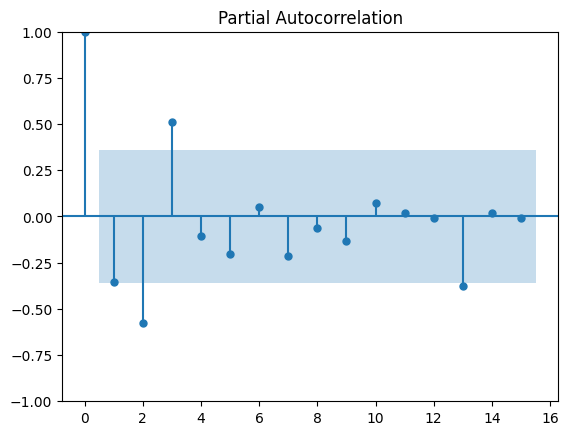

In [127]:
plot_pacf(X, method='ywm')
plt.show()

In [128]:
acorr_ljungbox(X, lags=[9])

,lb_stat,lb_pvalue
9,71.471994,7.828441e-12


In [129]:
sarima_model = auto_arima(
    X,
    start_p=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=3,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
    )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[3]             : AIC=15.981, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=28.135, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=20.044, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=14.441, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AIC=inf, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[3]             : AIC=16.404, Time=0.06 sec
 ARIMA(0,1,1)(0,1,2)[3]             : AIC=16.410, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[3]             : AIC=17.312, Time=0.04 sec
 ARIMA(0,1,1)(1,1,2)[3]             : AIC=18.410, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[3]             : AIC=20.740, Time=0.02 sec
 ARIMA(0,1,2)(0,1,1)[3]             : AIC=16.010, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[3]             : AIC=18.003, Time=0.03 sec
 ARIMA(1,1,2)(0,1,1)[3]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[3] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,1,1)[3]          
Total fit time: 0.987 s

In [130]:
print(sarima_model.aic())

14.441236822078361


In [131]:
train = X.loc[:'2016-12-31']
test = X.loc['2017-01-01':]

In [132]:
sarima_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 3),
      suppress_warnings=True, with_intercept=False)

In [133]:
sarima_future_forecast = sarima_model.predict(n_periods=9)

In [134]:
sarima_future_forecast.index

DatetimeIndex(['2017-04-30', '2017-08-31', '2017-12-31', '2018-04-30',
               '2018-08-31', '2018-12-31', '2019-04-30', '2019-08-31',
               '2019-12-31'],
              dtype='datetime64[ns]', freq='4ME')

In [135]:
sarima_future_forecast

2017-04-30    6.973606
2017-08-31    6.860178
2017-12-31    5.837003
2018-04-30    7.065031
2018-08-31    6.951603
2018-12-31    5.928427
2019-04-30    7.156456
2019-08-31    7.043027
2019-12-31    6.019852
Freq: 4ME, dtype: float64

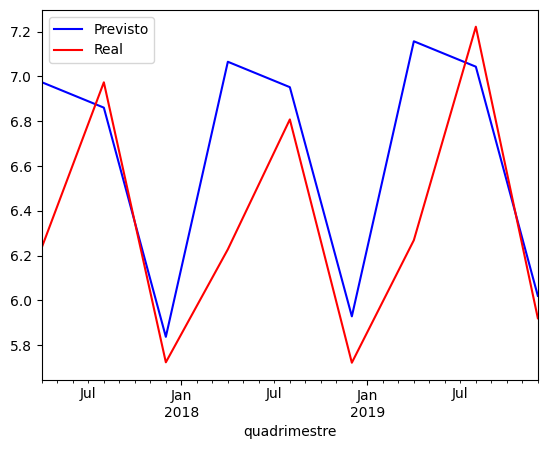

In [ ]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
test.plot(marker='', color='red', label='Real', legend=True)
plt.show()

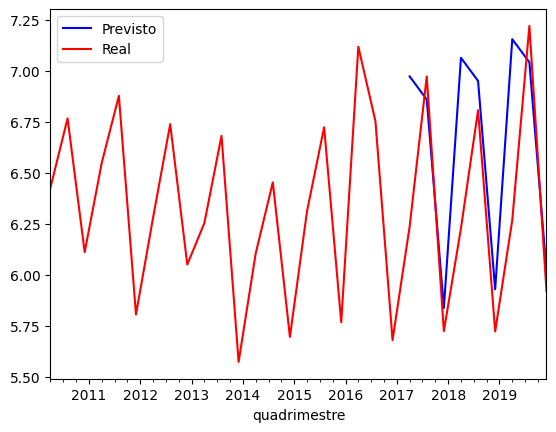

In [ ]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)
plt.show()

In [ ]:
# Parâmetros para calcular os intervalos de confiança

alpha_95 = 0.05 # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2 # Nível de significância para intervalo de confiança de 80%

# Valor crítico para distribuição normal padrão
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = sarima_future_forecast
forecast_std = np.std(train)

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

In [139]:
sarima_future_forecast.index

DatetimeIndex(['2017-04-30', '2017-08-31', '2017-12-31', '2018-04-30',
               '2018-08-31', '2018-12-31', '2019-04-30', '2019-08-31',
               '2019-12-31'],
              dtype='datetime64[ns]', freq='4ME')

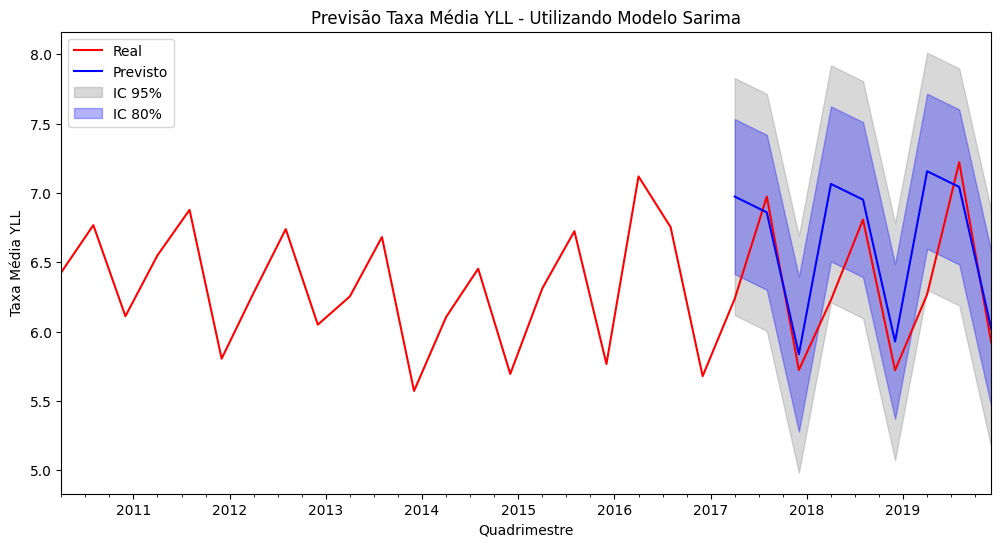

In [140]:
# Plotar previsão vs real com ambos intervalos de confiança
plt.figure(figsize=(12, 6))

X.plot(marker='', color='red', legend=True, label='Real')
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')

# Intervalo de 95%
plt.fill_between(sarima_future_forecast.index,
                 lower_bound_95, upper_bound_95,
                 color='gray', alpha=0.3, label='IC 95%')

# Intervalo de 80%
plt.fill_between(sarima_future_forecast.index,
                 lower_bound_80, upper_bound_80,
                 color='blue', alpha=0.3, label='IC 80%')

plt.title('Previsão Taxa Média YLL - Utilizando Modelo Sarima')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Quadrimestre')
plt.legend()
# plt.grid(True)
plt.show()

In [141]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test,sarima_future_forecast)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test,sarima_future_forecast)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(test,sarima_future_forecast)
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
TU = theil_u2(test, sarima_future_forecast)
print(f'TU: {TU}')

# Teste de Durbin-Watson
model_fit = sarima_model.fit(train)
dw = durbin_watson(model_fit.resid())
print(f'Durbin-Watson: {dw}')

MAE: 0.368711753904375
MSE: 0.2404250619948464
RMSE: 0.49033158372151225
MAPE: 0.05880862335073554
TU: 0.39339228414555216
Durbin-Watson: 1.0345817796822843
